In [1]:
import cv2
import ipympl
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import scipy.io
import hdf5storage
#import matplotlib
#matplotlib.use('nbagg')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean 
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.models import Model
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from keras import backend as K
import tensorflow as tf
import time
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from sklearn.metrics import classification_report
from keras.callbacks import TensorBoard
#indicate folder to save, plus other options
tensorboard = TensorBoard(log_dir='./logs/run', histogram_freq=1,
    write_graph=True, write_images=False)  

Using TensorFlow backend.


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
#file_name = "cardio.mat"
#file_name = "ionosphere.mat"
file_name = "satellite.mat"
#file_name = "shuttle.mat"
#file_name = "smtp.mat"
#file_name = "wine.mat"
#file_name = "arrhythmia.mat"
#file_name = "thyroid.mat"

noise_amount = 2
sparsity = 1 
kernel_reg = 0.01
bias_reg = 0.01
iterations = 5
dropout = 0.1
firstLayerSize = 100
secondLayerSize = 80
thirdLayerSize = 60
fourthLayerSize = 40
fifthLayerSize = 20
midLayerSize = 15

In [4]:
#mat = scipy.io.loadmat('cardio.mat')
#mat = scipy.io.loadmat('shuttle.mat')
#
#mat = hdf5storage.loadmat('smtp.mat')
#mat = scipy.io.loadmat('wine.mat')
#mat = scipy.io.loadmat('arrhythmia.mat')
#mat = scipy.io.loadmat('thyroid.mat')

mat = scipy.io.loadmat(file_name)
#mat = scipy.io.loadmat('satellite.mat')

In [5]:
epochs = 200
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=1)]
#callbacks = [EarlyStopping(monitor='val_loss', patience=1),tensorboard]

In [6]:
Xtemp = mat['X']
ytemp = mat['y']
X = np.array(Xtemp)
y = np.array(ytemp)
print(X.shape)
y = y.reshape(X.shape[0],)
print(y.shape)

(6435, 36)
(6435,)


In [7]:
outliers = 0
clean_data = []
contam_data = []

for i in range(y.shape[0]):
    if(y[i]==1.0):
        outliers+=1;
        contam_data.append(X[i])
    else:
        clean_data.append(X[i])
      

print("Total number of outliers in Dataset")        
print(outliers)
contam = outliers/y.shape[0]
print("Contamination in Dataset")
print(contam)
clean_data = np.array(clean_data)
contam_data = np.array(contam_data)
print(clean_data.shape)
clean_data2 = clean_data.copy()
contam_data2 = contam_data.copy()
# test_data_full = []
# for i in range(176):
#     test_data_full.append(contam_data[i])
# one = np.ones(176)
# test_data_full = np.array(test_data_full)

# test_data_full= np.append(test_data_full,one,1)

# print(test_data_full.shape)

Xy = X.copy()
Xy.shape
Xy = np.array(Xy)
Xy = np.insert(Xy, X.shape[1], y, axis=1)
#print(Xy.shape)
count = outliers
count2 = outliers


    
#selecting all the outliers from dataset
test_data =[]
for i in range(Xy.shape[0]):
    if(Xy[i,X.shape[1]]==1 and count>0):
        test_data.append(Xy[i])
        count = count-1
    
test_data = np.array(test_data)

#selecting random inliers from train data and removing them
indexes = np.random.choice(clean_data.shape[0], outliers, replace=False)

random_clean_data = clean_data[indexes, :]
random_clean_data = np.hstack((random_clean_data, np.zeros((random_clean_data.shape[0], 1), dtype=random_clean_data.dtype)))

indexes = indexes.reshape(outliers,1)

#deleting the values from train data
clean_data = np.delete(clean_data,indexes,0)
#print(clean_data)                
test_data = np.append(test_data,random_clean_data,axis=0)
np.random.shuffle(test_data)

print("test_data.shape")
print(test_data.shape)
#print(test_data.shape)
test_x = test_data[:,:test_data.shape[1]-1]
test_y = test_data[:,test_data.shape[1]-1]
#print(test_x.shape)
#print(test_y.shape)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

print("train_data.shape")                    
print(clean_data.shape)                         

Total number of outliers in Dataset
2036
Contamination in Dataset
0.3163947163947164
(4399, 36)
test_data.shape
(4072, 37)
train_data.shape
(2363, 36)


In [8]:
X_train, X_test = train_test_split(clean_data2,  test_size=0.03, random_state=42)
X_test = np.append(X_test,np.zeros((X_test.shape[0],1),dtype='float64'),axis=1)

inliers_test = X_test.shape[0]

contam_new = contam_data2.shape[0]/X_test.shape[0]
contam_data3 = np.append(contam_data2,np.ones((contam_data2.shape[0],1),dtype='float64'),axis=1)
outliers_test = contam_data3.shape[0]
X_test = np.append(X_test,contam_data3,axis=0)
np.random.shuffle(X_test)
Xy_test = X_test.copy
y_test = X_test[:,X_test.shape[1]-1]
#print(y_test.shape)
X_test = np.delete(X_test,X_test.shape[1]-1,axis=1)
#print(X_test.shape)

X_test_np = X_test
y_test_np = y_test
print(y_test.shape)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
print("Number of Outliers in Test")
print(outliers_test)
print("Number of Inliers in Test")
print(inliers_test)
#print(X_train)
#print(X_train.mean())
#print(pd.DataFrame(X_train).describe())
X_train_noisy = X_train
#noisy data
#print(X_train_noisy)
def apply_noise(col):
    #print(col.mean())
    mu, sigma = 0, abs(col.mean())
    noise = np.random.normal(mu, sigma, col.shape[0]) 
    for i  in range(col.shape[0]):
        col[i] += noise[i]

    return col
#print(X_train)
X_train_noisy = np.apply_along_axis(apply_noise, 0, X_train)

(2168,)
Number of Outliers in Test
2036
Number of Inliers in Test
132


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
clean_data = scaler.fit_transform(clean_data)
test_x  = scaler.transform(test_x)
clean_data = pd.DataFrame(clean_data)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
clean_data = pd.DataFrame(clean_data)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
                   0
Model 4     0.820321
Ensemble    0.808608
Ensemble2   0.810468
Model _de2  0.806249
Model _s2   0.801356
Model _s3   0.800444
Model c     0.801218


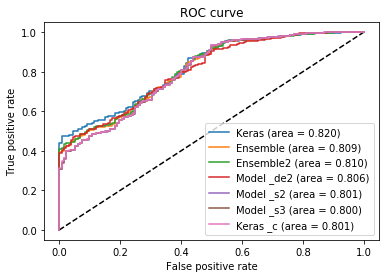

0
--- 35.57337474822998 seconds ---
                   0
Model 4     0.809133
Ensemble    0.802692
Ensemble2   0.799347
Model _de2  0.794889
Model _s2   0.801133
Model _s3   0.800072
Model c     0.801356


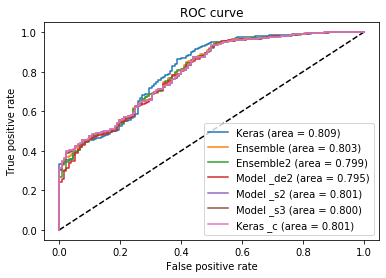

1
--- 70.89599895477295 seconds ---
                   0
Model 4     0.805888
Ensemble    0.805758
Ensemble2   0.805520
Model _de2  0.805348
Model _s2   0.801296
Model _s3   0.800288
Model c     0.801356


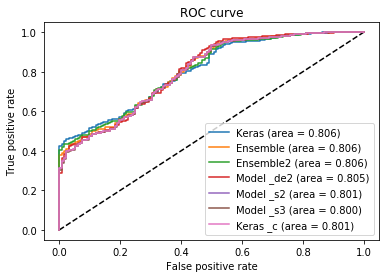

2
--- 64.56599926948547 seconds ---
                   0
Model 4     0.806000
Ensemble    0.803983
Ensemble2   0.811611
Model _de2  0.804388
Model _s2   0.800980
Model _s3   0.800303
Model c     0.801270


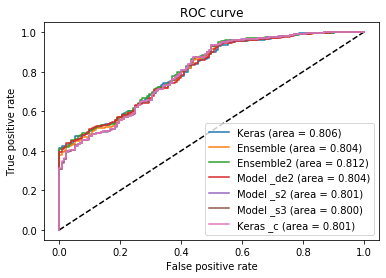

3
--- 88.21900153160095 seconds ---
                   0
Model 4     0.815495
Ensemble    0.805214
Ensemble2   0.812708
Model _de2  0.801594
Model _s2   0.800809
Model _s3   0.799678
Model c     0.801304


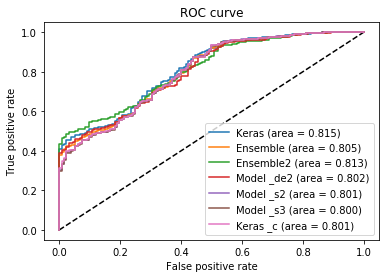

4
--- 117.03199744224548 seconds ---


In [10]:
for k in range(iterations): 
    #deep autoencoder
    start_time = time.time()
    inputs = Input(shape=(X.shape[1],))
   

    #deep autoencoder
    encoded3 = Dense(firstLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                     #,kernel_regularizer=l2(kernel_reg)
                     #,bias_regularizer=l2(bias_reg)
                    )(inputs)
    encoded3 = Dense(secondLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    #, kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3)
    encoded3 = Dense(thirdLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    #, kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3)
    encoded3 = Dense(fourthLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    #, kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3)
    encoded3 = Dense(fifthLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    #, kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3)
    encoded3 = Dense(midLayerSize, activation='relu'
                    #,kernel_regularizer=l2(kernel_reg)
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3)

    #decoded2 = Dense(80, activation='relu')(encoded2)
    decoded3 = Dense(fifthLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(encoded3)
    decoded3 = Dense(fourthLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3)
    decoded3 = Dense(thirdLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3)
    decoded3 = Dense(secondLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3)
    decoded3 = Dense(firstLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3)
    decoded3 = Dense(X.shape[1], activation='tanh')(decoded3)

    autoencoder3 = Model(inputs, decoded3)
    for num, layer in enumerate(autoencoder3.layers):
        layer._name = 'autoencoder3_' + str(num)+'_'+str(k)
    #autoencoder3.summary()
    autoencoder3.compile(optimizer='adam', loss='mse')

    autoencoder3.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
                   )

    #encoded_data = encoder.predict(test_x)
    decoded_data3 = autoencoder3.predict(X_test)

    #print(dict(zip(unique, counts)))
    mse3 = np.mean(np.power(X_test - decoded_data3, 2), axis=1)
    mse3 = mse3.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse3 = scaler.fit_transform(mse3)
    
    #deep autoencoder
    encoded3_c = Dense(firstLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                     ,kernel_regularizer=l2(kernel_reg)
                     ,bias_regularizer=l2(bias_reg)
                    )(inputs)
    encoded3_c = Dense(secondLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(kernel_reg) 
                    ,bias_regularizer=l2(bias_reg)
                    )(encoded3_c)
    encoded3_c = Dense(thirdLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(kernel_reg) 
                    ,bias_regularizer=l2(bias_reg)
                    )(encoded3_c)
    encoded3_c = Dense(fourthLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(kernel_reg) 
                    ,bias_regularizer=l2(bias_reg)
                    )(encoded3_c)
    encoded3_c = Dense(fifthLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(kernel_reg) 
                    ,bias_regularizer=l2(bias_reg)
                    )(encoded3_c)
    encoded3_c = Dense(midLayerSize, activation='relu'
                    ,kernel_regularizer=l2(kernel_reg)
                    ,bias_regularizer=l2(bias_reg)
                    )(encoded3_c)

    #decoded2 = Dense(80, activation='relu')(encoded2)
    decoded3_c = Dense(fifthLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                    , kernel_regularizer=l2(kernel_reg)
                    ,bias_regularizer=l2(bias_reg)
                    )(encoded3_c)
    decoded3_c = Dense(fourthLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                    , kernel_regularizer=l2(kernel_reg)
                    ,bias_regularizer=l2(bias_reg)
                    )(decoded3_c)
    decoded3_c = Dense(thirdLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                    , kernel_regularizer=l2(kernel_reg)
                    ,bias_regularizer=l2(bias_reg)
                    )(decoded3_c)
    decoded3_c = Dense(secondLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                    , kernel_regularizer=l2(kernel_reg)
                    ,bias_regularizer=l2(bias_reg)
                    )(decoded3_c)
    decoded3_c = Dense(firstLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                    , kernel_regularizer=l2(kernel_reg) 
                    ,bias_regularizer=l2(bias_reg)
                    )(decoded3_c)
    decoded3_c = Dense(X.shape[1], activation='tanh')(decoded3_c)

    autoencoder3_c = Model(inputs, decoded3_c)
    for num, layer in enumerate(autoencoder3_c.layers):
        layer._name = 'autoencoder3_c_' + str(num)+'_'+str(k)
    #autoencoder3.summary()
    autoencoder3_c.compile(optimizer='adam', loss='mse')

    autoencoder3_c.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
                   )

    #encoded_data = encoder.predict(test_x)
    decoded_data3_c = autoencoder3_c.predict(X_test)

    #print(dict(zip(unique, counts)))
    mse3_c = np.mean(np.power(X_test - decoded_data3_c, 2), axis=1)
    mse3_c = mse3_c.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse3_c = scaler.fit_transform(mse3_c)
    
    #deep autoencoder
    encoded3_s2 = Dense(firstLayerSize, activation='relu'
                   # ,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg)
                   # ,bias_regularizer=l2(bias_reg)
                     )(inputs)
    encoded3_s2 = Dense(secondLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                   # ,bias_regularizer=l2(bias_reg)
                    )(encoded3_s2)
    encoded3_s2 = Dense(thirdLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_s2)
    encoded3_s2 = Dense(fourthLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_s2)
    encoded3_s2 = Dense(fifthLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_s2)
    encoded3_s2 = Dense(midLayerSize, activation='relu'
                      ,activity_regularizer=regularizers.l1(sparsity)
    #                  kernel_regularizer=l2(kernel_reg), 
    #                 bias_regularizer=l2(bias_reg)
                    )(encoded3_s2)

    #decoded2 = Dense(80, activation='relu')(encoded2)
    decoded3_s2 = Dense(fifthLayerSize, activation='relu'
                   #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(encoded3_s2)
    decoded3_s2 = Dense(fourthLayerSize, activation='relu'
                   #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s2)
    decoded3_s2 = Dense(thirdLayerSize, activation='relu'
                   #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s2)
    decoded3_s2 = Dense(secondLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s2)
    decoded3_s2 = Dense(firstLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s2)
    decoded3_s2 = Dense(X.shape[1], activation='tanh')(decoded3_s2)

    autoencoder3_s2 = Model(inputs, decoded3_s2)
    
    for num, layer in enumerate(autoencoder3_s2.layers):
        layer._name = 'autoencoder3_s2_' + str(num)+'_'+str(k)
    autoencoder3_s2.compile(optimizer='adam', loss='mse')
    #autoencoder3_s2.summary()

    autoencoder3_s2.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    decoded_data3_s2 = autoencoder3_s2.predict(X_test)
    mse3_s2 = np.mean(np.power(X_test - decoded_data3_s2, 2), axis=1)
    mse3_s2 = mse3_s2.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse3_s2 = scaler.fit_transform(mse3_s2)
     
    #sparse autoencoder new
    encoded3_s3 = Dense(firstLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg)
                   # ,bias_regularizer=l2(bias_reg)
                     )(inputs)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)
    encoded3_s3 = Dense(secondLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                   # ,bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)
    encoded3_s3 = Dense(thirdLayerSize, activation='relu'
                   # ,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)
    encoded3_s3 = Dense(fourthLayerSize, activation='relu'
                   # ,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)
    encoded3_s3 = Dense(fifthLayerSize, activation='relu'
                   # ,activity_regularizer=regularizers.l1(sparsity)
                   # ,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)
    encoded3_s3 = Dense(midLayerSize, activation='relu'
                      ,activity_regularizer=regularizers.l1(sparsity)
    #                  kernel_regularizer=l2(kernel_reg), 
    #                 bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    encoded3_s3 = Dropout(dropout)(encoded3_s3)

    #decoded2 = Dense(80, activation='relu')(encoded2)
    decoded3_s3 = Dense(fifthLayerSize, activation='relu'
                   #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(encoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)
    decoded3_s3 = Dense(fourthLayerSize, activation='relu'
                   #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)
    decoded3_s3 = Dense(thirdLayerSize, activation='relu'
                   #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)
    decoded3_s3 = Dense(secondLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)
    decoded3_s3 = Dense(firstLayerSize, activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)
    decoded3_s3 = Dense(X.shape[1], activation='tanh')(decoded3_s3)
    decoded3_s3 = Dropout(dropout)(decoded3_s3)

    autoencoder3_s3 = Model(inputs, decoded3_s3)
    
    for num, layer in enumerate(autoencoder3_s3.layers):
        layer._name = 'autoencoder3_s3_' + str(num)+'_'+str(k)
        
    autoencoder3_s3.compile(optimizer='adam', loss='mse')
    #autoencoder3_s3.summary()

    autoencoder3_s3.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    decoded_data3_s3 = autoencoder3_s3.predict(X_test)
    mse3_s3 = np.mean(np.power(X_test - decoded_data3_s3, 2), axis=1)
    mse3_s3 = mse3_s3.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse3_s3 = scaler.fit_transform(mse3_s3)
    
    #deep autoencoder
    encoded3_de2 = Dense(firstLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    #,kernel_regularizer=l2(kernel_reg)
                    #,bias_regularizer=l2(bias_reg)
                    )(inputs)
    encoded3_de2 = Dense(secondLayerSize, activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                   # ,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_de2)
    encoded3_de2 = Dense(thirdLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    #,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_de2)
    encoded3_de2 = Dense(fourthLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    #,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_de2)
    encoded3_de2 = Dense(fifthLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    #,kernel_regularizer=l2(kernel_reg) 
                    #,bias_regularizer=l2(bias_reg)
                    )(encoded3_de2)
    encoded3_de2 = Dense(midLayerSize, activation='relu'
    #                  ,
    #                  kernel_regularizer=l2(kernel_reg), 
    #                 bias_regularizer=l2(bias_reg)
                    )(encoded3_de2)

    #decoded2 = Dense(80, activation='relu')(encoded2)
    decoded3_de2 = Dense(fifthLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(encoded3_de2)
    decoded3_de2 = Dense(fourthLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_de2)
    decoded3_de2 = Dense(thirdLayerSize, activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_de2)
    decoded3_de2 = Dense(secondLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_de2)
    decoded3_de2 = Dense(firstLayerSize, activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(kernel_reg), 
                   # bias_regularizer=l2(bias_reg)
                    )(decoded3_de2)
    decoded3_de2 = Dense(X.shape[1], activation='tanh')(decoded3_de2)

    autoencoder3_de2 = Model(inputs, decoded3)
    
    for num, layer in enumerate(autoencoder3_de2.layers):
        layer._name = 'autoencoder3_de2_' + str(num)+'_'+str(k)
        
        
    autoencoder3_de2.compile(optimizer='adam', loss='mse')
    
    
    
    #autoencoder3_de2.summary()

    autoencoder3_de2.fit(X_train_noisy, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    decoded_data3_de2 = autoencoder3_de2.predict(X_test)

    mse3_de2 = np.mean(np.power(X_test - decoded_data3_de2, 2), axis=1)
    mse3_de2 = mse3_de2.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    mse3_de2 = scaler.fit_transform(mse3_de2)
    
    ensemble = [];
    for i in range(0,mse3.size):
        ensemble.append(0.25*mse3_de2[i]+0.25*mse3_s3[i]+0.25*mse3[i] +0.25*mse3_s2[i])


    from tensorflow.keras.layers import concatenate
    from tensorflow.keras.layers import Average
    from tensorflow.keras.models import Model
  
    #x = concatenate([decoded3_de2, decoded3_s3,decoded3,decoded3_s2])  # merge the outputs of the two models
    x = Average()([decoded3_de2, decoded3_s3,decoded3,decoded3_s2])  # merge the outputs of the two models

    
#     out = Dense(10,activation='tanh'
#                 #, kernel_regularizer=l2(kernel_reg) 
#                # , bias_regularizer=l2(bias_reg)
#                )(x)
    out = Dense(X.shape[1],activation='tanh'
                #, kernel_regularizer=l2(kernel_reg) 
                #, bias_regularizer=l2(bias_reg)
               )(x)  # final layer of the network
    model = Model(inputs=inputs, outputs=out)
    for l in model.layers:
        l.trainable = False

    model.layers[len(model.layers)-1].trainable = True
#     model.layers[len(model.layers)-2].trainable = True
#     model.layers[len(model.layers)-3].trainable = True

#     for l in model.layers:
#         print(l.trainable)




    #model.summary()
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, X_train,
                    epochs=500,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    ensemble_pred = model.predict(X_test)
    #print(ensemble_pred)
    ensemble2_mse = np.mean(np.power(X_test - ensemble_pred, 2), axis=1)
    ensemble2_mse = ensemble2_mse.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    ensemble2_mse = scaler.fit_transform(ensemble2_mse)


    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc

    fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test, mse3)
    fpr_keras5, tpr_keras5, thresholds_keras5 = roc_curve(y_test, ensemble2_mse)
    fpr_keras_de2, tpr_keras_de2, thresholds_keras_de2 = roc_curve(y_test, mse3_de2)
    fpr_keras_s2, tpr_keras_s2, thresholds_keras_s2 = roc_curve(y_test, mse3_s2)
    fpr_keras_s3, tpr_keras_s3, thresholds_keras_s3 = roc_curve(y_test, mse3_s3)
    fpr_kerasE, tpr_kerasE, thresholds_kerasE = roc_curve(y_test, ensemble)
    fpr_keras3_c, tpr_keras3_c, thresholds_keras3_c = roc_curve(y_test, mse3_c)
    #print(thresholds_keras2)


    auc_keras3 = auc(fpr_keras3, tpr_keras3)
    auc_kerasE = auc(fpr_kerasE, tpr_kerasE)
    auc_keras5 = auc(fpr_keras5, tpr_keras5)
    auc_keras_de2 = auc(fpr_keras_de2, tpr_keras_de2)
    auc_keras_s2 = auc(fpr_keras_s2, tpr_keras_s2)
    auc_keras_s3 = auc(fpr_keras_s3, tpr_keras_s3)
    auc_keras3_c = auc(fpr_keras3_c, tpr_keras3_c)
    a = pd.DataFrame([auc_keras3, auc_kerasE, auc_keras5, auc_keras_de2, auc_keras_s2, auc_keras_s3, auc_keras3_c], ["Model 4", "Ensemble", "Ensemble2", "Model _de2", "Model _s2", "Model _s3", "Model c"])
    print(a)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
    plt.plot(fpr_kerasE, tpr_kerasE, label='Ensemble (area = {:.3f})'.format(auc_kerasE))
    plt.plot(fpr_keras5, tpr_keras5, label='Ensemble2 (area = {:.3f})'.format(auc_keras5))
    plt.plot(fpr_keras_de2, tpr_keras_de2, label='Model _de2 (area = {:.3f})'.format(auc_keras_de2))
    plt.plot(fpr_keras_s2, tpr_keras_s2, label='Model _s2 (area = {:.3f})'.format(auc_keras_s2))
    plt.plot(fpr_keras_s3, tpr_keras_s3, label='Model _s3 (area = {:.3f})'.format(auc_keras_s3))
    plt.plot(fpr_keras3_c, tpr_keras3_c, label='Keras _c (area = {:.3f})'.format(auc_keras3_c))
    #plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    if(k==0):
        sums = [auc_keras3, auc_kerasE, auc_keras5, auc_keras_de2, auc_keras_s2, auc_keras_s3 , auc_keras3_c];
    else:
        temp = [auc_keras3, auc_kerasE, auc_keras5, auc_keras_de2, auc_keras_s2, auc_keras_s3, auc_keras3_c]
        for tempi in range(0,len(sums)):
            sums[tempi] = sums[tempi]+temp[tempi];
    

    import csv
    from datetime import date
    with open('resultsAllModels4.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        if(k==iterations-1):
            today = date.today()
            d1 = today.strftime("%d/%m/%Y")
            writer.writerow([d1])
            writer.writerow([file_name])
            writer.writerow(["params","noise_amount",noise_amount,"sparsity" ,sparsity,"kernel_reg", kernel_reg,"bias_reg" ,bias_reg,"iterations" ,iterations])
            writer.writerow(["Model 4", "Ensemble", "Ensemble2", "Model _de2", "Model _s2", "Model _s3", "Model c"])
            writer.writerow([x/iterations for x in sums])
    print(k)
    print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
"
# outputs = [layer.output for layer in autoencoder2_s.layers]
# #print(outputs[0].eval())
# # Initialize session 
# # or, for passing in a layer directly
# def get_all_outputs(model, input_data, learning_phase=1):
#     outputs = [layer.output for layer in model.layers[1:]] # exclude Input
#     layers_fn = K.function([model.input, K.learning_phase()], outputs)
#     return layers_fn([input_data, learning_phase])

# #print(get_all_outputs(autoencoder2_s,X_test))
# for i in range(len(get_all_outputs(autoencoder2_s,X_test)[1])):
#     plt.plot(get_all_outputs(autoencoder2_s,X_test)[1][i])
    
# print((get_all_outputs(autoencoder2_s,X_test)[0][0]))
#plt.hist(get_all_outputs(autoencoder2_s,X_test)[0][0])
#plt.hist(get_all_outputs(autoencoder2_s,X_test)[0][1])
#plt.hist(get_all_outputs(autoencoder2_s,X_test)[0][2])
a = [];
a = a[:]+[4,5,6]
a = a[:]+[4,5,6]

print()


SyntaxError: EOL while scanning string literal (<ipython-input-11-9c989fe19b78>, line 1)

In [ ]:
clean_pd = pd.DataFrame(clean_data2)
clean_pd.describe()

In [ ]:
clean_pd = pd.DataFrame(clean_data2)
clean_pd.describe()

In [ ]:
clean_pd = pd.DataFrame(clean_data2)
clean_pd.describe()

In [ ]:
clean_pd = pd.DataFrame(clean_data2)
clean_pd.describe()

In [ ]:
# for i in range(len(get_all_outputs(autoencoder2,X_test)[1])):
#     plt.plot(get_all_outputs(autoencoder2,X_test)[1][i])

In [ ]:
import keract
from keract import get_gradients_of_trainable_weights

c = keract.get_gradients_of_activations(autoencoder3_de2, X_test, X_test)
for key, value in c.items():
    if('dense' in key):
        plt.plot(c[key])
#print(b)

In [ ]:
import keract
from keract import get_gradients_of_trainable_weights
from keract import get_gradients_of_activations


a = keract.get_gradients_of_activations(autoencoder3_s3, X_train, X_train)
#print(a)
for key, value in a.items():
    if('dense' in key):
        plt.plot(a[key])
    


In [ ]:


d = keract.get_gradients_of_activations(autoencoder3_s2, X_train, X_train)
#print(a)
for key, value in d.items():
    if('dense' in key):
        plt.plot(d[key])
    

In [ ]:

e = keract.get_gradients_of_activations(autoencoder2_s, X_train, X_train)
#print(a)
for key, value in e.items():
    if('dense' in key):
        plt.plot(e[key])
    

In [ ]:
w = keract.get_gradients_of_activations(autoencoder2, X_train, X_train)
#print(a)
for key, value in w.items():
    if('dense' in key):
        plt.plot(w[key])
    

#plt.hist(a['dense_704/bias:0'])

In [ ]:
import keract
from keract import get_gradients_of_trainable_weights

b = keract.get_gradients_of_activations(autoencoder3, X_train, X_train)
#print(a)
for key, value in b.items():
    if('dense' in key):
        plt.plot(b[key])
    

In [ ]:


for l in autoencoder3_s3.layers:
        for a in l.get_weights():
            plt.hist(a)
            
    

In [ ]:
for l in autoencoder3_s2.layers:
        for a in l.get_weights():
            plt.hist(a)

In [ ]:
for l in autoencoder3.layers:
        for a in l.get_weights():
            plt.hist(a)

In [ ]:
for l in autoencoder2_de.layers:
        for a in l.get_weights():
            plt.hist(a)